In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning

In [52]:
data = pd.read_csv(r'C:\Users\karen\OneDrive\Escritorio\Especializacion\ML1\data\fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [45]:
# Me fijo si hay observaciones duplicadas
duplic = data.duplicated()
num_duplicates = duplic.sum()
print("Cantidad de filas duplicadas:", num_duplicates)

Cantidad de filas duplicadas: 0


In [53]:
# Eliminar columnas irrelevantes 
data = data.drop(["nameOrig", "nameDest"], axis=1)

In [54]:
data.shape

(6362620, 9)

In [48]:
# Veo si hay missing values
data.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [49]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [17]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [18]:
# Separo tipos de variables para analizar

# Obtener los nombres de las columnas categóricas
cat_cols = data.select_dtypes(include='object').columns
print("Variables categóricas en el dataset:")
for col in cat_cols:
    print(col)

# Obtener los nombres de las columnas numéricas
num_cols = data.select_dtypes(include='number').columns
print("Variables numéricas en el dataset:")
for col in num_cols:
    print(col)

Variables categóricas en el dataset:
type
Variables numéricas en el dataset:
step
amount
oldbalanceOrg
newbalanceOrig
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud


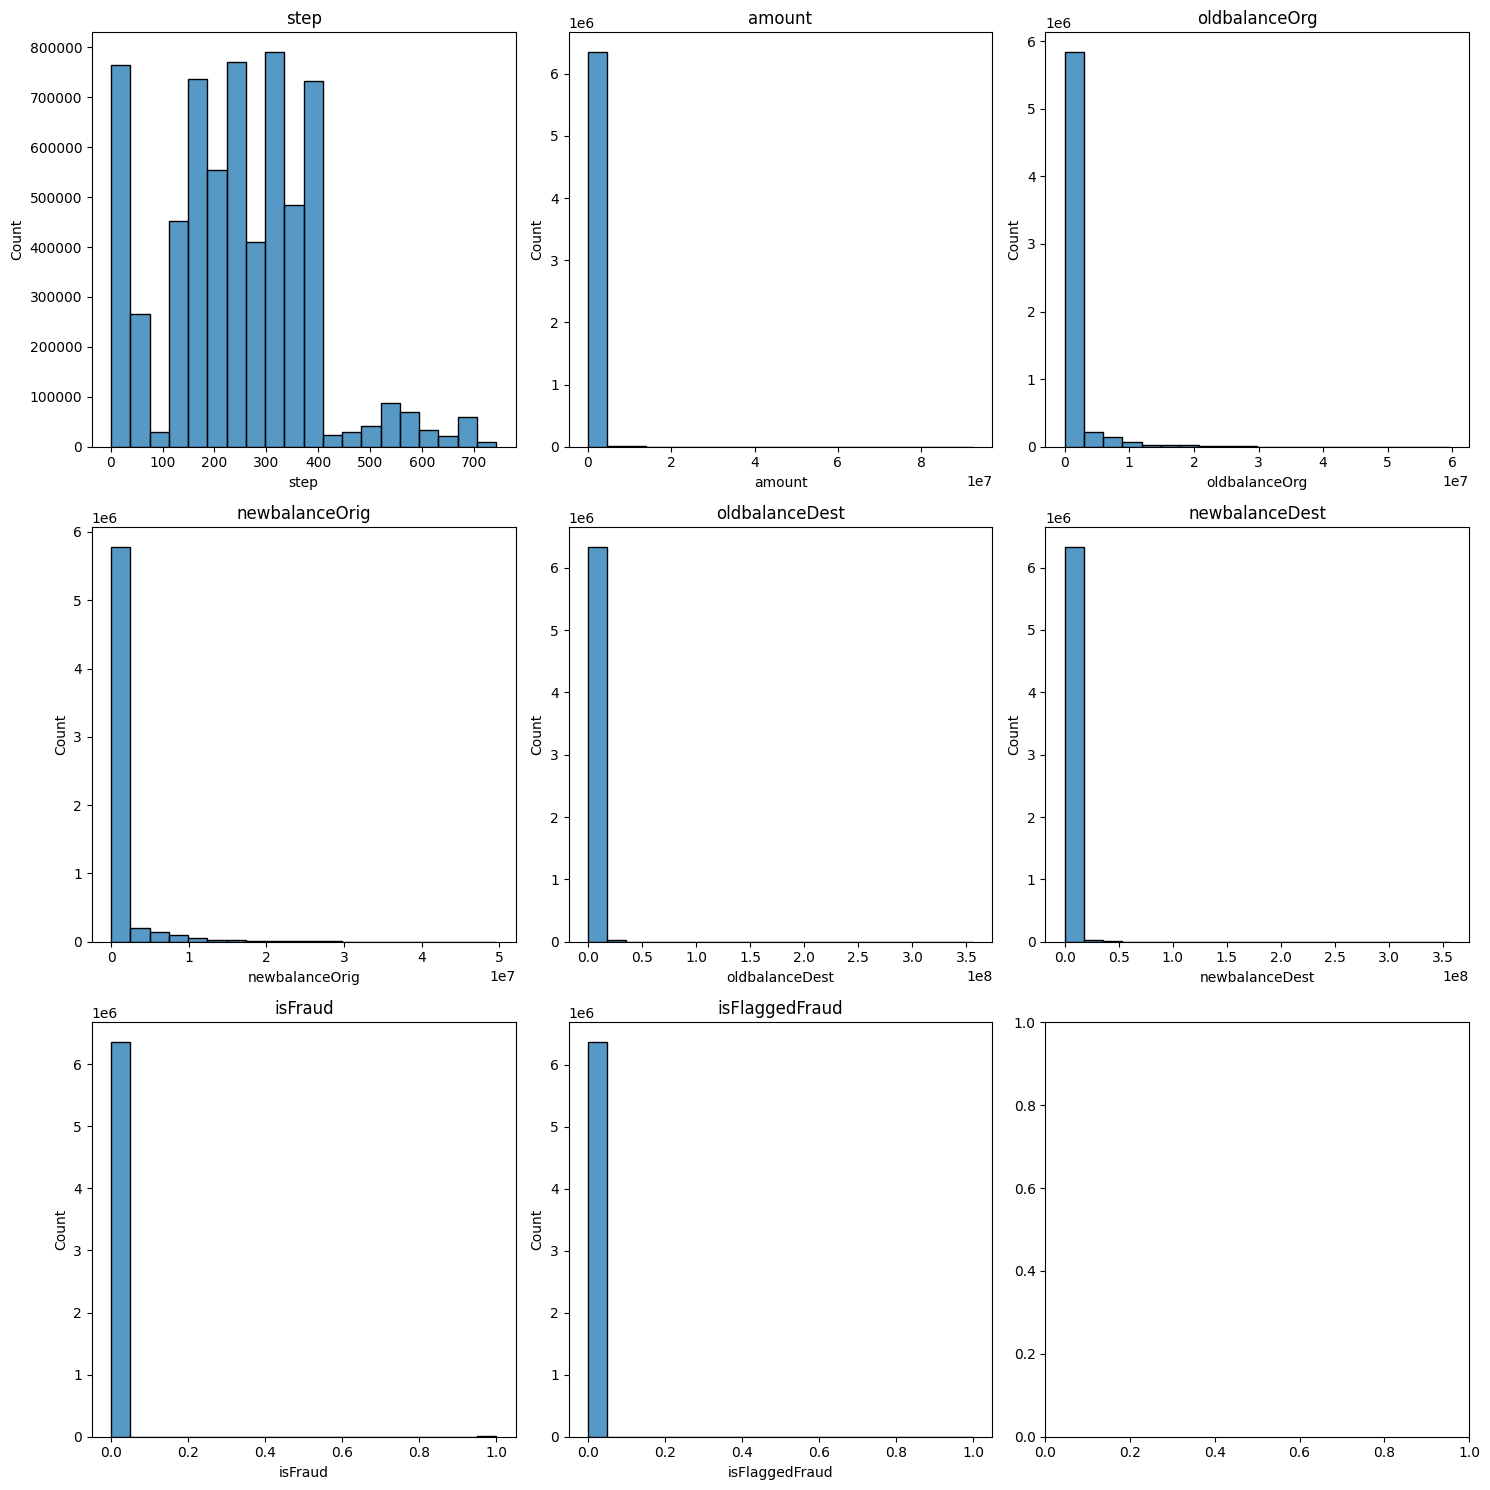

In [19]:
# Explorar las variables numéricas
if num_cols.any():
    num_col = 3
    num_row = -(-len(num_cols) // num_col)  # ceil division
    fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(15, 5*num_row))

    for i, col in enumerate(num_cols):
        row = i // num_col
        sns.histplot(data[col], ax=axs[row, i % num_col], bins=20)
        axs[row, i % num_col].set(title=col)

    plt.tight_layout()
    plt.savefig('histograms.png', dpi=300)
    plt.show()
else:
    print("No hay variables numéricas en los datos.")

In [20]:
# Verificar el balance de clases
fraud_count = data["isFraud"].sum()
non_fraud_count = len(data) - fraud_count
fraud_percentage = (fraud_count / len(data)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 8213 (0.13%)
Transacciones no fraudulentas: 6354407 (99.87%)


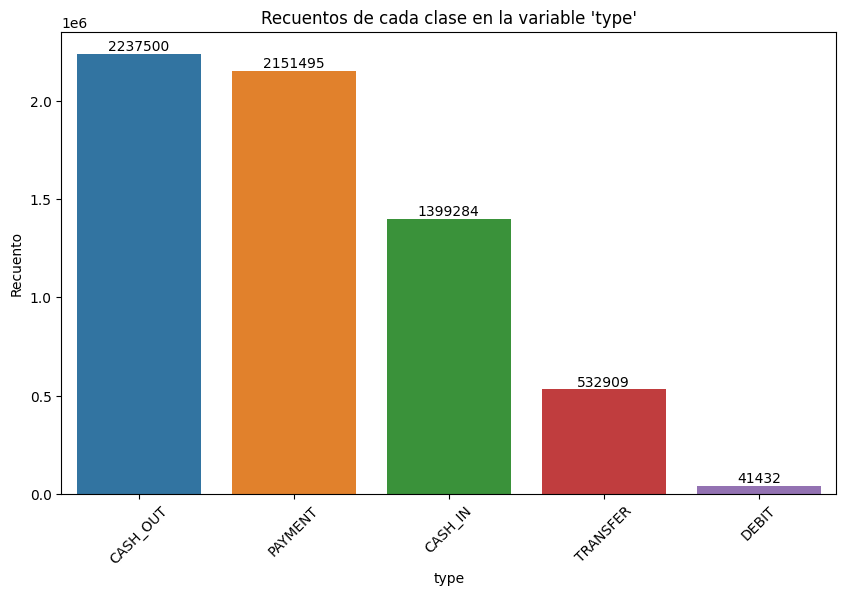

In [21]:
# Exploro los tipos de transacción

# Obtener los recuentos de cada clase
counts = data['type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title(f"Recuentos de cada clase en la variable '{'type'}'")
plt.xlabel('type')
plt.ylabel("Recuento")
plt.xticks(rotation=45)

# Agregar los valores en las barras
for i, count in enumerate(counts.values):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [5]:
# Calcular los recuentos de cada categoría y la cantidad de elementos fraudulentos y no fraudulentos
counts = data['type'].value_counts()
fraud_counts = data[data['isFraud'] == 1]['type'].value_counts()
non_fraud_counts = data[data['isFraud'] == 0]['type'].value_counts()

# Crear la tabla
tabla = pd.DataFrame({'Recuento total': counts, 'Recuento de fraudes': fraud_counts, 'Recuento de no fraudes': non_fraud_counts})
tabla.index.name = 'type'

print(tabla)

          Recuento total  Recuento de fraudes  Recuento de no fraudes
type                                                                 
CASH_IN          1399284                  NaN                 1399284
CASH_OUT         2237500               4116.0                 2233384
DEBIT              41432                  NaN                   41432
PAYMENT          2151495                  NaN                 2151495
TRANSFER          532909               4097.0                  528812


Sólo hay transacciones fraudulentas en CASH_OUT y TRANSFER

In [55]:
types = data['type'].unique()

for type_value in types:
    globals()[f"{type_value.lower()}_df"] = data[data['type'] == type_value].copy()
    globals()[f"{type_value.lower()}_df"].drop('type', axis=1, inplace=True)

In [56]:
transfer_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,181.00,181.00,0.0,0.00,0.00,1,0
19,1,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0


In [57]:
cash_out_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,181.00,181.00,0.0,21182.0,0.00,1,0
15,1,229133.94,15325.00,0.0,5083.0,51513.44,0,0
42,1,110414.71,26845.41,0.0,288800.0,2415.16,0,0
47,1,56953.90,1942.02,0.0,70253.0,64106.18,0,0
48,1,5346.89,0.00,0.0,652637.0,6453430.91,0,0


### Transfer

In [58]:
# Verificar el balance de clases
fraud_count = transfer_df["isFraud"].sum()
non_fraud_count = len(transfer_df) - fraud_count
fraud_percentage = (fraud_count / len(transfer_df)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 4097 (0.77%)
Transacciones no fraudulentas: 528812 (99.23%)


In [59]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = transfer_df.drop('isFraud', axis=1)
y = transfer_df['isFraud']

In [79]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
3243756,250,3315876.61,5412.0,0.0,94702.35,3410578.96,0
4938043,350,1196860.54,57074.0,0.0,69766.62,1266627.15,0
5083950,355,261328.52,40006.0,0.0,0.00,261328.52,0
336698,16,466989.62,137.0,0.0,0.00,787420.08,0
1317264,136,487035.87,159111.0,0.0,0.00,487035.87,0


In [84]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5,6
0,0.023845,1.286311,-0.112077,-0.040191,-0.411442,-0.018442,-0.00508
1,0.713620,0.153542,0.006025,-0.040191,-0.415603,-0.310889,-0.00508
2,0.748108,-0.346568,-0.032994,-0.040191,-0.427246,-0.448018,-0.00508
3,-1.590227,-0.236627,-0.124136,-0.040191,-0.427246,-0.376256,-0.00508
4,-0.762498,-0.225911,0.239285,-0.040191,-0.427246,-0.417230,-0.00508


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 3.11
--------------------
Iteración: 3
Peso de clase: 5.22
--------------------
Iteración: 4
Peso de clase: 7.33
--------------------
Iteración: 5
Peso de clase: 9.44
--------------------
Iteración: 6
Peso de clase: 11.56
--------------------
Iteración: 7
Peso de clase: 13.67
--------------------
Iteración: 8
Peso de clase: 15.78
--------------------
Iteración: 9
Peso de clase: 17.89
--------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteración: 10
Peso de clase: 20.0
--------------------


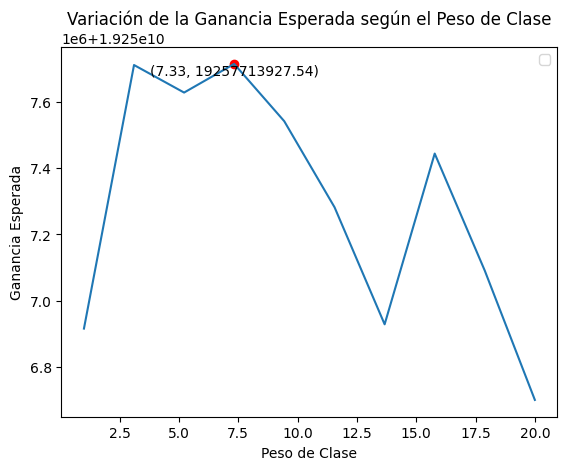

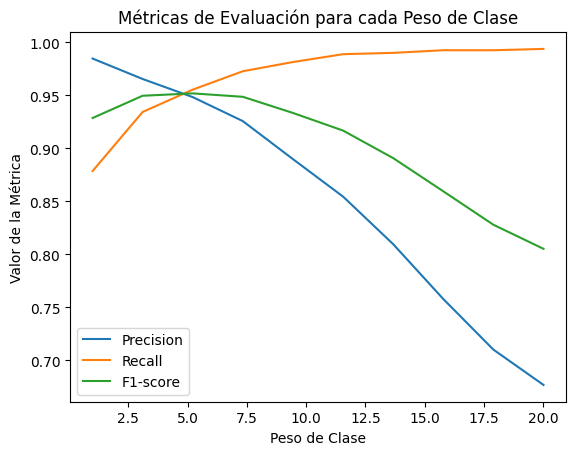

In [91]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0077
# weights = np.linspace(1, desbalance, 30) 
weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

Pruebo usando pesos menores para la clase mayoritaria

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.11
--------------------
Iteración: 3
Peso de clase: 1.22
--------------------
Iteración: 4
Peso de clase: 1.33
--------------------
Iteración: 5
Peso de clase: 1.44
--------------------
Iteración: 6
Peso de clase: 1.56
--------------------
Iteración: 7
Peso de clase: 1.67
--------------------
Iteración: 8
Peso de clase: 1.78
--------------------
Iteración: 9
Peso de clase: 1.89
--------------------
Iteración: 10
Peso de clase: 2.0
--------------------


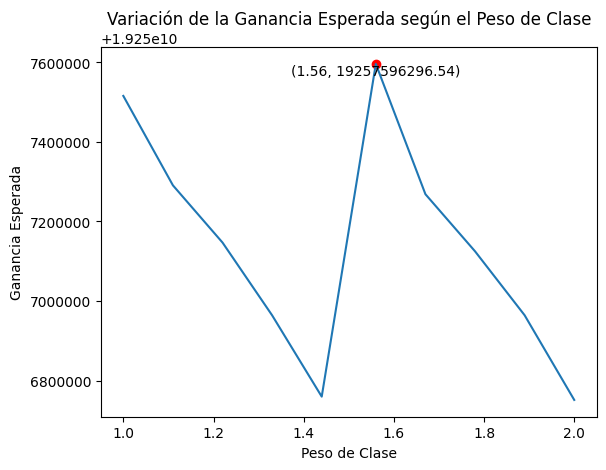

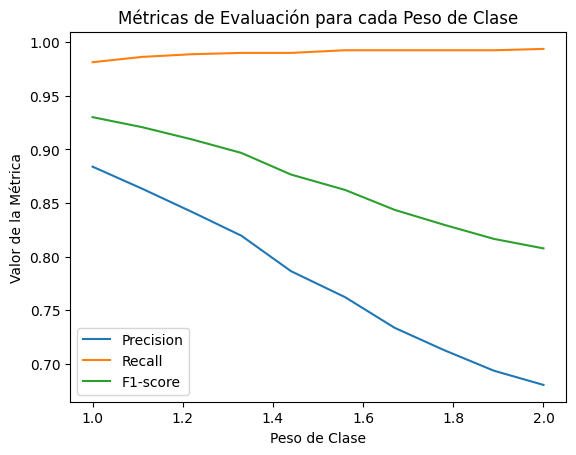

In [92]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = np.linspace(1, 2, 10) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, se le asigna un peso de 0.1 a la clase no fraude
    class_weights = {0: 0.1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random forest

Peso de clase: 1
Precision: 0.9950372208436724
Recall: 0.9938042131350682
F1 Score: 0.9944203347799132
Ganancia: 19268754898.022
--------------------
Peso de clase: 10
Precision: 0.9950372208436724
Recall: 0.9938042131350682
F1 Score: 0.9944203347799132
Ganancia: 19268754898.022
--------------------
Peso de clase: 20
Precision: 0.9950372208436724
Recall: 0.9938042131350682
F1 Score: 0.9944203347799132
Ganancia: 19268754898.022
--------------------
Peso de clase: 30
Precision: 0.9950372208436724
Recall: 0.9938042131350682
F1 Score: 0.9944203347799132
Ganancia: 19268754898.022
--------------------
Peso de clase: 40
Precision: 0.9950372208436724
Recall: 0.9938042131350682
F1 Score: 0.9944203347799132
Ganancia: 19268754898.022
--------------------
Peso de clase: 50
Precision: 0.9938118811881188
Recall: 0.9950433705080545
F1 Score: 0.9944272445820433
Ganancia: 19268727200.744
--------------------
Peso de clase: 60
Precision: 0.9950433705080545
Recall: 0.9950433705080545
F1 Score: 0.99504337

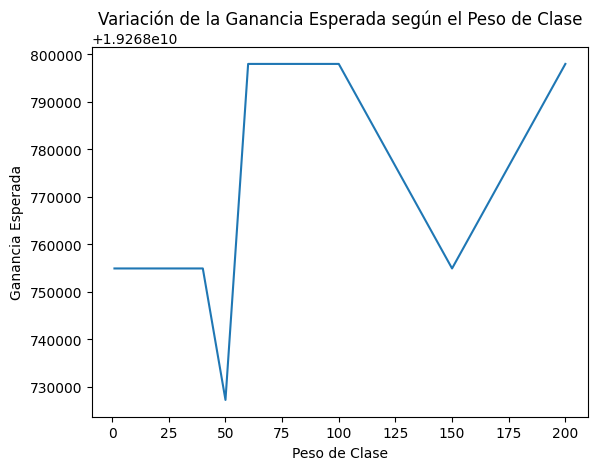

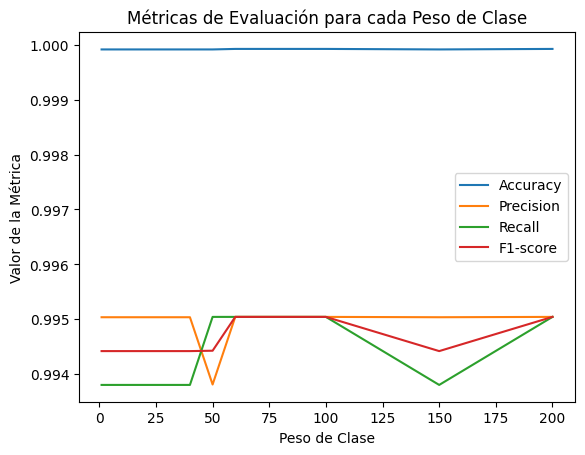

In [14]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
profits = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterar sobre los diferentes pesos de clase
for weight in weights:
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Peso de clase:", weight)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Ganancia:", profit)
    print("--------------------")

# Gráfico de ganancias
plt.plot(weights, profits)
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.show()

# Gráfico de métricas
plt.plot(weights, accuracy_scores, label='Accuracy')
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

In [12]:
profits

[19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268754898.022,
 19268797990.022]

##### Modelo final para TRANSFER

#### Cash_out

Para incorporar la optimización de las ganancias en el entrenamiento del modelo de clasificación, se puede usar Cost-Sensitive Learning. Esta técnica asigna pesos diferentes a las clases en función de su costo asociado, de modo que el modelo se enfoque en minimizar los errores costosos.

In [29]:
# Codificar las variables categóricas
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [27]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [28]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Al utilizar pesos de clase ajustados y el umbral óptimo, el modelo se enfocará en maximizar la ganancia esperada durante el entrenamiento y la clasificación.

Recuerda que es importante ajustar los pesos de clase de acuerdo a la relación de costos específica de tu problema y realizar experimentos para encontrar el equilibrio adecuado entre maximizar la ganancia y mantener una buena precisión en la detección de fraudes.

In [31]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = [1, 5, 10, 20]
profits = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterar sobre los diferentes pesos de clase
for weight in weights:
    # Calcular los pesos de clase
    class_weights = {1: weight} # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    total_transactions = len(y_test)
    fraud_transactions = tp + fn
    approved_transactions = tn + fp
    profit = (approved_transactions * 0.2 * X_test['amount'].sum()) - (fraud_transactions * X_test['amount'].sum())
    profits.append(profit)

    # Imprimir los resultados
    print("Peso de clase:", weight)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Ganancia:", profit)
    print("--------------------")

# Gráfico de ganancias
plt.bar(weights, profits)
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.show()

# Gráfico de métricas
plt.plot(weights, accuracy_scores, label='Accuracy')
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

KeyboardInterrupt: 

##### Modelo final para CASH_OUT